# **DATA UNDERSTANDING**

## **Context**

The Sakila Database holds information about a company that rents movie DVDs. For this project, we will explore the database to gain more insight focusing on **Film**. This project will focused on 2 tables, that we will query through SQL.

1. Film focused table
2. Rental duration, Sales and Country


## Database Information

In [1]:
from IPython import display

!['sakila'](https://www.jooq.org/img/sakila.png)

| No. | Table | Description
| :-- | -- | -- |
| 1 | actor | lists information for all actors |
| 2 | address | contains address information for customers, staff, and stores |
| 3 | category | lists the categories that can be assigned to a film |
| 4 | city | contains a list of cities |
| 5 | country | contains a list of countries |
| 6 | customer | contains a list of all customers |
| 7 | film | list of all films potentially in stock in the stores |
| 8 | film_actor | for each actor in a given film, there will be one row in the film_actor table listing the actor and film |
| 9 | film_category | for each category applied to a film, there will be one row in the film_category table listing the category and film |
| 10 | film_text | contains the film_id, title and description columns of the film table |
| 11 | inventory | contains one row for each copy of a given film in a given store |
| 12 | language | listing the possible languages that films can have for their language and original language values |
| 13 | payment | records each payment made by a customer, with information such as the amount and the rental being paid for |
| 14 | rental | contains one row for each rental of each inventory item with information about who rented what item, when it was rented, and when it was returned |
| 15 | staff | lists all staff members, including information for email address, login information, and picture |
| 16 | store | lists all stores in the system |

## **DATABASE**

### **Connecting to Database**

In this section we will connect to the SAKILA database. Thus we will install mysql-connector-python, so we can use our SQL queries and access the dataframe.

In [2]:
%pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import modules

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as sqlcon

In [4]:
# Connect to database

mydb = sqlcon.connect(
    host = 'localhost',
    user = 'root',
    passwd = 'Mysql033?!',
    database = 'sakila'
)

We also need to write a function to write a ``query`` that will saved as a ``DataFrame``. The tables that we will use are constructed from a few tables, so we will need to write the query for the needed tables. As we need to form 2 tables, we will need to use this function to form our tables and save it to a datafame.


In [5]:
# Write function

curs = mydb.cursor()

def sql_table(query):
    curs.execute(query)
    result = curs.fetchall()
    table1 = pd.DataFrame(result, columns=curs.column_names)
    return table1

### **All About Film**

In this table we will see a combination from 4 tables (category, film, language, inventory). This table will describe the Film's details, such as the inventory_id, category, title, release year, language, film length, rating, rental duration, and rental rate.

| Column | Table Origin | Description |
| :-- | :-- | :-- | 
| inventory_id | inventory | Number of inventory |
| category | category | Film category |
| title | film | Film title |
| release_year | film | Film release year |
| language | language | Film language |
| length | film | Film duration (in minutes) |
| rating | film | Film rating (G, PG, PG-13, etc) |
| rental_duration | film | Length of rental period in days | 
| rental_rate | film | Cost to rent the film for the period specified in the rental_duration |

This table will be saved as **df_film**.

In [6]:
# Query 1

df_film = sql_table(
    '''
    SELECT 
        i.inventory_id,
        c.name AS category,
        f.title,
        f.release_year,
        l.name AS language,
        f.length,
        f.rating,
        f.rental_duration,
        f.rental_rate
    FROM
        film_category AS fc
            JOIN category AS c 
                ON c.category_id = fc.category_id
            JOIN film AS f 
                ON f.film_id = fc.film_id
            JOIN language AS l 
                ON l.language_id = f.language_id
            JOIN inventory AS i 
                ON f.film_id = i.film_id;
        '''
)

df_film.head()


,inventory_id,category,title,release_year,language,length,rating,rental_duration,rental_rate
0,4530,Travel,WORKING MICROCOSMOS,2006,English,74,R,4,4.99
1,4531,Travel,WORKING MICROCOSMOS,2006,English,74,R,4,4.99
2,4532,Travel,WORKING MICROCOSMOS,2006,English,74,R,4,4.99
3,4533,Travel,WORKING MICROCOSMOS,2006,English,74,R,4,4.99
4,4534,Travel,WORKING MICROCOSMOS,2006,English,74,R,4,4.99


### **Rental Duration and Geography**


In this table we will see a combination from 6 tables (rental, category, film, payment, country, city). This table will show the actual rental duration and actual income per category. We will also look if there are any geographical relation with the category.

| Column | Table Origin | Description |
| :-- | :-- | :-- |
| rental_id | rental | Unique key that identifies the rental |
| category | category | Film category |
| rating | film | Film rating (G, PG, PG-13, etc) |
| rental_rate | film | Cost to rent the film for the period specified in the rental_duration column |
| rental_duration | film | Length of the rental period in days |
| rental_length_day | film | Actual rental days (return_date - rental_date) |
| rental_date | rental | Actual rental day |
| payment | payment | The amount of payment (sum(amount)) |
| country | country | Where the rental takes place (country) |
| city | city | Where the rental takes place (city) |

This table will be saved as **df_durcon**.

In [7]:
# Query 2

df_durcon = sql_table(
    '''
    SELECT 
        r.rental_id,
        ca.name AS category,
        f.rating,
        f.rental_rate,
        f.rental_duration,
        DATEDIFF(r.return_date, r.rental_date) AS rental_length_day,
        SUM(p.amount) AS payment,
        r.rental_date,
        co.country,
        ci.city
    FROM
        film_category AS fc
            JOIN category AS ca 
                ON ca.category_id = fc.category_id
            JOIN film AS f 
                ON fc.film_id = f.film_id
            JOIN inventory AS i 
                ON f.film_id = i.film_id
            JOIN rental AS r 
                ON i.inventory_id = r.inventory_id
            JOIN payment AS p 
                ON r.rental_id = p.rental_id
            JOIN customer AS cu 
                ON cu.customer_id = p.customer_id
            JOIN address AS a 
                ON a.address_id = cu.address_id
            JOIN city AS ci 
                ON ci.city_id = a.city_id
            JOIN country AS co 
                ON co.country_id = ci.country_id
    GROUP BY rental_id
    ORDER BY country;  
    '''
)

df_durcon.head()

,rental_id,category,rating,rental_rate,rental_duration,rental_length_day,payment,rental_date,country,city
0,1459,Games,R,0.99,5,7.0,2.99,2005-06-15 20:25:53,Afghanistan,Kabul
1,7090,Comedy,R,4.99,7,2.0,4.99,2005-07-27 04:43:53,Afghanistan,Kabul
2,7236,Action,PG-13,4.99,3,7.0,8.99,2005-07-27 10:09:39,Afghanistan,Kabul
3,9018,Classics,NC-17,2.99,4,8.0,6.99,2005-07-30 05:28:40,Afghanistan,Kabul
4,9902,New,G,0.99,3,9.0,6.99,2005-07-31 14:24:33,Afghanistan,Kabul


### **Additional Info for Rating**

The table below is for rating abbreviation reference.

| Rating | Description | Remarks |
| :-- | :-- | :--|
| G | General Audiences | All ages admitted |
| PG | Parental Guidance Suggested | Some material may not be suitable for children |
| PG-13 | Parents Strongly Cautioned | Some material may be inappropriate for children under 13 |
| R | Restricted | Under 17 requires accompanying parent or adult guardian |
| NC-17 | No one 17 and under admitted |   |


# **DATA MANIPULATION**

In this section we will prepare the data (missing value, data types, etc) so that we have a reliable dataframe that can be analyzed.

## **Data Anomalies**

In [8]:
# Check table's info

df_film.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   inventory_id     4581 non-null   int64 
 1   category         4581 non-null   object
 2   title            4581 non-null   object
 3   release_year     4581 non-null   int64 
 4   language         4581 non-null   object
 5   length           4581 non-null   int64 
 6   rating           4581 non-null   object
 7   rental_duration  4581 non-null   int64 
 8   rental_rate      4581 non-null   object
dtypes: int64(4), object(5)
memory usage: 322.2+ KB


In [9]:
df_durcon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rental_id          16044 non-null  int64         
 1   category           16044 non-null  object        
 2   rating             16044 non-null  object        
 3   rental_rate        16044 non-null  object        
 4   rental_duration    16044 non-null  int64         
 5   rental_length_day  15861 non-null  float64       
 6   payment            16044 non-null  object        
 7   rental_date        16044 non-null  datetime64[ns]
 8   country            16044 non-null  object        
 9   city               16044 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 1.2+ MB


## **Data Review**

From the information above we can see that there are a few issues with missing values and data type. 

**df_film**
<br>
While there are no missing values on all the columns, we have wrong data type assigned to the rental_rate column. The rental_rate column is the rate of borrowing film in dollar. The data type should be float not object.

**df_durcon**
<br>
We have missing values on the rental_length_day and the wrong data type also assigned to the rental_rate and payment column. 


In [10]:
# Check if there are missing values on df_film

df_film.isna().sum()

inventory_id       0
category           0
title              0
release_year       0
language           0
length             0
rating             0
rental_duration    0
rental_rate        0
dtype: int64

In [11]:
# Check if there are missing values on df_durcon

df_durcon.isna().sum()

rental_id              0
category               0
rating                 0
rental_rate            0
rental_duration        0
rental_length_day    183
payment                0
rental_date            0
country                0
city                   0
dtype: int64

In [12]:
# Check if there are duplicate values on df_film

df_film.duplicated().sum()

0

In [13]:
# Check if there are duplicate values on df_durcon

df_durcon.duplicated().sum()

0

## **Missing Values**

In this section we will decide on how to treat the missing value on rental_length_day column. The missing value takes 1.1% of the overall data, this we will fill the missing values with either mean or median. First, we will see all the statistical information on the rental_length_day.

In [14]:
df_durcon['rental_length_day'].describe()

count    15861.000000
mean         5.025219
std          2.611835
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: rental_length_day, dtype: float64

As we can see the mean and median have similar values, thus we can conclude that our data is normally distributed. In this project we will use the median, which is 5.

In [15]:
# Write the fillna command

df_durcon['rental_length_day'].fillna(df_durcon['rental_length_day'].median(), inplace=True)

In [16]:
# Check if there are still exist missing values

df_durcon.isna().sum()

rental_id            0
category             0
rating               0
rental_rate          0
rental_duration      0
rental_length_day    0
payment              0
rental_date          0
country              0
city                 0
dtype: int64

We can see that all the values on the columns are 0, this means there are no blank row exist

## **Change Data Type**

In this section we will treat the columns that have wrong data type.

They are:
1. df_film['rental_rate'] object --> float
2. df_durcon['rental_rate'] object --> float
3. df_durcon['total_sales'] object --> float

In [17]:
# Check the data type

df_film.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   inventory_id     4581 non-null   int64 
 1   category         4581 non-null   object
 2   title            4581 non-null   object
 3   release_year     4581 non-null   int64 
 4   language         4581 non-null   object
 5   length           4581 non-null   int64 
 6   rating           4581 non-null   object
 7   rental_duration  4581 non-null   int64 
 8   rental_rate      4581 non-null   object
dtypes: int64(4), object(5)
memory usage: 322.2+ KB


In [18]:
df_durcon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rental_id          16044 non-null  int64         
 1   category           16044 non-null  object        
 2   rating             16044 non-null  object        
 3   rental_rate        16044 non-null  object        
 4   rental_duration    16044 non-null  int64         
 5   rental_length_day  16044 non-null  float64       
 6   payment            16044 non-null  object        
 7   rental_date        16044 non-null  datetime64[ns]
 8   country            16044 non-null  object        
 9   city               16044 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 1.2+ MB


In [19]:
# Change df_film['rental_rate']
df_film['rental_rate'] = df_film['rental_rate'].astype('float')

# Change df_durcon['rental_rate']
df_durcon['rental_rate'] = df_durcon['rental_rate'].astype('float')

# Change df_durcon['payment']
df_durcon['payment'] = df_durcon['payment'].astype('float')

In [20]:
# Check the data types

df_film.dtypes

inventory_id         int64
category            object
title               object
release_year         int64
language            object
length               int64
rating              object
rental_duration      int64
rental_rate        float64
dtype: object

In [21]:
df_durcon.dtypes

rental_id                     int64
category                     object
rating                       object
rental_rate                 float64
rental_duration               int64
rental_length_day           float64
payment                     float64
rental_date          datetime64[ns]
country                      object
city                         object
dtype: object

## Feature Month

Extracting rental month information from datetime data (rental_date).

In [22]:
import datetime as dt
from datetime import datetime

In [23]:
df_durcon['month'] = pd.DatetimeIndex(df_durcon['rental_date']).month

## **Preview Cleaned Data**

In [24]:
# Clean Data

df_film.sample(10)

,inventory_id,category,title,release_year,language,length,rating,rental_duration,rental_rate
1037,2065,New,IDAHO LOVE,2006,English,172,PG-13,3,2.99
563,464,Sports,BUBBLE GROSSE,2006,English,60,R,4,4.99
2961,2809,Documentary,NATIONAL STORY,2006,English,92,NC-17,4,2.99
79,2956,Travel,OUTLAW HANKY,2006,English,148,PG-13,7,4.99
1263,2368,Music,LEGEND JEDI,2006,English,59,PG,7,0.99
1288,1735,Music,GREATEST NORTH,2006,English,93,NC-17,5,2.99
226,340,Travel,BIRD INDEPENDENCE,2006,English,163,G,6,4.99
3988,3970,Animation,SUNRISE LEAGUE,2006,English,135,PG-13,3,4.99
4304,4186,Action,TRIP NEWTON,2006,English,64,PG-13,7,4.99
4296,4210,Action,TRUMAN CRAZY,2006,English,92,G,7,4.99


In [25]:
df_durcon.sample(10)

,rental_id,category,rating,rental_rate,rental_duration,rental_length_day,payment,rental_date,country,city,month
1268,12759,Sci-Fi,PG,2.99,3,5.0,7.98,2006-02-14 15:16:03,Brazil,Santo Andr,2
2693,11672,Games,R,4.99,3,5.0,4.99,2006-02-14 15:16:03,China,Yingkou,2
130,63,Children,G,0.99,3,2.0,0.99,2005-05-25 09:19:16,Angola,Namibe,5
11966,13761,Sports,PG-13,4.99,6,1.0,4.99,2005-08-20 11:28:50,Russian Federation,Kurgan,8
4122,5268,Animation,NC-17,0.99,4,3.0,0.99,2005-07-09 14:22:43,Egypt,Shubra al-Khayma,7
10297,6229,Foreign,PG,2.99,5,9.0,6.99,2005-07-11 13:59:50,Pakistan,Okara,7
12809,7062,Family,G,2.99,3,7.0,6.99,2005-07-27 03:52:01,Spain,Ourense (Orense),7
7373,14889,Classics,R,4.99,4,2.0,4.99,2005-08-22 04:10:10,Japan,Hiroshima,8
4984,10104,Horror,G,0.99,4,5.0,1.99,2005-07-31 20:49:14,India,Haldia,7
9975,7422,Classics,G,0.99,5,7.0,2.99,2005-07-27 17:10:42,Nigeria,Effon-Alaiye,7


## **General Info Cleaned Data**

In [26]:
# Build a function to chect some info

def table_info(DF):

    listItem = []

    for col in DF.columns:
        listItem.append([col, DF[col].dtype, len(DF), DF[col].isna().sum(), round((DF[col].isna().sum()/len(DF[col]))*100,2),DF[col].nunique()])

    DFDesc = pd.DataFrame(columns=['Column Name', 'Data Type', 'Data Count','Missing Value','Missing Value Percentage','Number of Unique'],data=listItem)

    return DFDesc


In [27]:
# Check info on df_film

table_info(df_film)

,Column Name,Data Type,Data Count,Missing Value,Missing Value Percentage,Number of Unique
0,inventory_id,int64,4581,0,0.0,4581
1,category,object,4581,0,0.0,16
2,title,object,4581,0,0.0,958
3,release_year,int64,4581,0,0.0,1
4,language,object,4581,0,0.0,1
5,length,int64,4581,0,0.0,140
6,rating,object,4581,0,0.0,5
7,rental_duration,int64,4581,0,0.0,5
8,rental_rate,float64,4581,0,0.0,3


In [28]:
# Check info on df_durcon

table_info(df_durcon)

,Column Name,Data Type,Data Count,Missing Value,Missing Value Percentage,Number of Unique
0,rental_id,int64,16044,0,0.0,16044
1,category,object,16044,0,0.0,16
2,rating,object,16044,0,0.0,5
3,rental_rate,float64,16044,0,0.0,3
4,rental_duration,int64,16044,0,0.0,5
5,rental_length_day,float64,16044,0,0.0,11
6,payment,float64,16044,0,0.0,19
7,rental_date,datetime64[ns],16044,0,0.0,15815
8,country,object,16044,0,0.0,108
9,city,object,16044,0,0.0,597


## **Grouping & Aggregating**

We will see the basic information about the data (count of title, average rental rate, etc) by grouping and aggregating the tables.

### Count of Film title grouped by category and rating

In [29]:
pd.pivot_table(data=df_film, index='category', columns='rating', values='inventory_id', aggfunc='count')

rating,G,NC-17,PG,PG-13,R
category,,,,,
Action,84,40,47,59,82
Animation,71,72,56,95,41
Children,48,60,54,60,47
Classics,52,45,47,63,63
Comedy,53,46,79,54,37
Documentary,55,58,82,38,61
Drama,53,82,35,104,26
Family,41,56,85,52,76
Foreign,51,44,61,86,58


### Average rental rate grouped by rating and rental_duration


In [30]:
pd.pivot_table(data=df_film, index='rating', columns='rental_duration', values='rental_rate', aggfunc='mean')

rental_duration,3,4,5,6,7
rating,,,,,
G,2.914051,2.541020,3.565000,2.542941,2.434444
NC-17,3.012099,3.033165,3.334828,2.925223,2.921034
PG,2.634444,3.175185,3.015478,2.724043,3.230437
PG-13,3.054516,2.561429,3.434444,3.035662,3.194301
R,2.304010,3.212222,2.757196,3.070645,2.919078


### Total sales by category

In [31]:
df_durcon.groupby('category')[['category','payment']].sum().sort_values(by='payment', ascending=False)

,payment
category,
Sports,5314.21
Sci-Fi,4756.98
Animation,4656.30
Drama,4587.39
Comedy,4383.58
Action,4375.85
New,4351.62
Games,4281.33
Foreign,4270.67


### Total sales by rating

In [32]:
df_durcon.groupby('rating')[['rating','payment']].sum().sort_values(by='payment', ascending=False)

,payment
rating,
PG-13,15259.16
NC-17,13875.07
PG,13337.91
R,13270.19
G,11664.23


### Total sales by country

In [33]:
df_durcon.groupby('country')[['country','payment']].sum().sort_values(by='payment', ascending=False)

,payment
country,
India,6628.28
China,5798.74
United States,4110.32
Japan,3470.75
Mexico,3307.04
...,...
Tunisia,78.77
Tonga,73.82
Lithuania,73.76


## **Data Outlier**

We will check if there are outlier on rental_length_day (this is the actual rental day of the film). This variable only available on df_durcon.

In [34]:
# Outlier with function

Q1 = df_durcon['rental_length_day'].describe()['25%']
Q3 = df_durcon['rental_length_day'].describe()['75%']
iqr = Q3 - Q1 

df_durcon[(df_durcon['rental_length_day'] < Q1 - (1.5 * iqr)) | (df_durcon['rental_length_day'] > Q3 + (1.5 * iqr))]['rental_length_day'].count()


0

# **DATA VISUALIZATION AND STATISTICS**

In [35]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Current film inventory and Highest contribution

### Current film inventory

In [36]:
# Make dataframe for the chart (count aggregate)

fig1_df = pd.DataFrame()

fig1_df['category'] = df_film['category'].unique()
fig1_df['count'] = list(df_film.groupby('category')['category'].aggregate('count'))

fig1_df

,category,count
0,Travel,312
1,Sports,335
2,Sci-Fi,269
3,New,270
4,Music,269
5,Horror,294
6,Games,300
7,Foreign,310
8,Family,300
9,Drama,276


In [37]:
fig1 = px.bar(  fig1_df, 
                y='category',
                x = 'count', 
                orientation='h', 
                title = 'Current Film Inventory',
                height=500,
                color_discrete_sequence=['green'])

fig1.update_layout(barmode='stack', yaxis ={'categoryorder':'total ascending'})

fig1.show()

From the chart above, we can conclude that the top 5 of our film inventory are Sports, Animation, Sci-Fi, Action, and Family.

### Highest contributors

In [38]:
df_fig2 = df_durcon.groupby('category')[['category','payment']].sum().sort_values('payment', ascending=False)

fig2 = px.bar(  data_frame=df_fig2,
                orientation='h',
                title='Total Income Contribution by Category',
                height=500)

fig2.update_layout(yaxis ={'categoryorder':'total ascending'})


fig2.show()

From the chart above, we can see that our top 5 contributor categories are Sports, Sci-Fi, Animation, Drama, and Comedy.

If you compare both of the chart we will see difference between the inventory and contribution.

| Top Inventory | Top Contributor |
| :-- | :-- |
| Sports | Sports |
| Animation | Sci-Fi |
| Sci-Fi | Animation |
| Family | Comedy |

With this information we will now see the average rate per category and the rental frequency.

Then we can decide if there are any need to increase the inventory or adjust the rental rate / rental duration

## Rental frequencies per category

In [44]:
# Make dataframe for the plot

df_3 = pd.DataFrame()

df_3['category'] = df_film['category'].unique()

df_3['rental_freq'] = list(df_durcon.groupby('category')['rental_id'].count())

df_3['inventory'] = list(df_film.groupby('category')['category'].aggregate('count'))

df_3['payment'] = list(round(df_durcon.groupby('category')['payment'].sum()))

df_3 = df_3.sort_values(by='rental_freq', ascending=False)

df_3

,category,rental_freq,inventory,payment
14,Animation,1179,344,5314.0
1,Sports,1166,335,4656.0
0,Travel,1112,312,4376.0
13,Children,1101,312,4757.0
7,Foreign,1096,310,4226.0
6,Games,1060,300,4587.0
5,Horror,1050,294,4218.0
8,Family,1033,300,4271.0
9,Drama,969,276,4281.0
2,Sci-Fi,945,269,3656.0


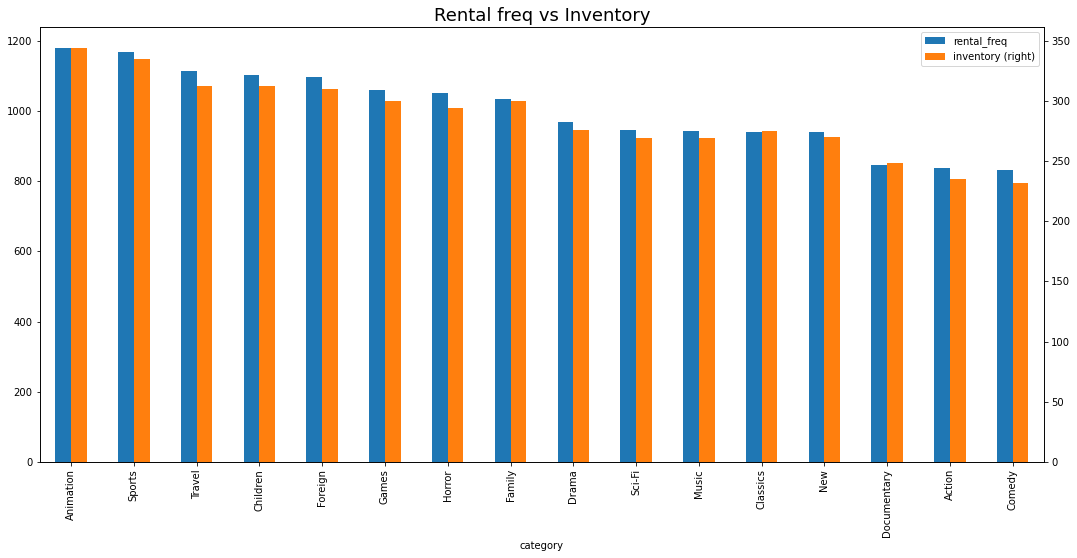

In [45]:
df_3.plot(x='category',y=['rental_freq','inventory'], kind='bar', stacked=False, secondary_y =['inventory'], figsize = (18,8))

plt.title('Rental freq vs Inventory', size=18)

plt.show()

As we can see from the table above, the supply does complement the rental frequency. Thus we further explore the rental rate to find if there are any difference in average payment.

## Average rate per category

In [39]:
# Normality test on 'payment' variable based on category

from scipy.stats import normaltest  # N > 500

norm, pval = normaltest(df_durcon['payment'])

if pval < 0.05:
    print('pvalue < 0.05, reject Ho')
    print('The data is not normally distributed')
else:
    print('pvalue > 0.05, failed to reject Ho')
    print('The data is normally distributed')

pvalue < 0.05, reject Ho
The data is not normally distributed


In [40]:
# Kruskal Wallis to check if there are any differences between the median of each categories' payment

from scipy.stats import kruskal

stat, pvalue = kruskal(
    df_durcon[df_durcon['category'] == 'Sports']['payment'],
    df_durcon[df_durcon['category'] == 'Sci-Fi']['payment'],
    df_durcon[df_durcon['category'] == 'Animation']['payment'],
    df_durcon[df_durcon['category'] == 'Drama']['payment'],
    df_durcon[df_durcon['category'] == 'Comedy']['payment'],
    df_durcon[df_durcon['category'] == 'Action']['payment'],
    df_durcon[df_durcon['category'] == 'New']['payment'],
    df_durcon[df_durcon['category'] == 'Games']['payment'],
    df_durcon[df_durcon['category'] == 'Foreign']['payment'],
    df_durcon[df_durcon['category'] == 'Family']['payment'],
    df_durcon[df_durcon['category'] == 'Documentary']['payment'],
    df_durcon[df_durcon['category'] == 'Horror']['payment'],
    df_durcon[df_durcon['category'] == 'Children']['payment'],
    df_durcon[df_durcon['category'] == 'Classics']['payment'],
    df_durcon[df_durcon['category'] == 'Travel']['payment'],
    df_durcon[df_durcon['category'] == 'Music']['payment']
)

if pvalue < 0.05 :
    print('pvalue < 0.05, reject Ho')
    print('There are payment median differences between each category')
else:
    print('pvalue > 0.05, failed to reject Ho')
    print('There are no payment median difference betwewn each category')

pvalue < 0.05, reject Ho
There are payment median differences between each category


Now we know that there are difference on the rental_rate for each category. With this data we can conclude that there are difference on the rate between category, that can cause the difference in rental_freq and contribution.

## Overtime contribution

We want to see how many of our payments are penalize because of overtime.

In [182]:
# Create dataset
df_6 = pd.DataFrame(df_durcon[['category','month','rental_duration','rental_length_day','payment']])

df_6['overtime'] = df_6['rental_length_day'] - df_6['rental_duration']

df_6['overtime'] = df_6['overtime'].apply(lambda x: 'Yes' if x >0 else 'No')

df_6

,category,month,rental_duration,rental_length_day,payment,overtime
0,Games,6,5,7.0,2.99,Yes
1,Comedy,7,7,2.0,4.99,No
2,Action,7,3,7.0,8.99,Yes
3,Classics,7,4,8.0,6.99,Yes
4,New,7,3,9.0,6.99,Yes
...,...,...,...,...,...,...
16039,Drama,8,3,2.0,4.99,No
16040,Sci-Fi,6,4,3.0,4.99,No
16041,Comedy,6,6,2.0,0.99,No
16042,Horror,7,5,2.0,4.99,No


In [183]:
df_6_1 = df_6.groupby(['category','overtime'])['payment'].sum().reset_index()

fig6 = px.treemap(
            df_6_1,
            path=['overtime','category'],
            values='payment',
                width=1500,
            height=600,
            color_continuous_scale='YlGnBu',
            title='Penalty Contribution to Payment'
        )

fig6.show()

Most of our payment are penalize with overdue, such we can conclude that our default rental duration are not fit to the customer's need and have to be adjusted. Below is the reference for the adjustment.

In [184]:
df_adj = df_durcon.groupby(['category','rating'])[['rental_duration','rental_length_day']].mean().reset_index()
df_adj

,category,rating,rental_duration,rental_length_day
0,Action,G,5.172881,5.189831
1,Action,NC-17,4.867133,4.909091
2,Action,PG,4.725610,5.097561
3,Action,PG-13,5.209302,4.841860
4,Action,R,4.610169,5.023729
...,...,...,...,...
75,Travel,G,4.931298,4.877863
76,Travel,NC-17,6.007194,4.920863
77,Travel,PG,5.872247,4.709251
78,Travel,PG-13,5.362069,4.879310


## Payment Trend by Month

We want to see the payment trend by month, to see if there are any dips on the rental income.

In [67]:
# Create dataset
df_4 = df_durcon.groupby('month')[['payment']].sum().reset_index()

In [72]:
fig4 = px.line(df_4, x='month',y='payment',  title='Payment by Month', markers=True)

fig4.show()

There is a significant increase on month 7 and a slight decrease on month 8. We will now check if there are any connection between this and the geographical data.

## Rental Location

We want to see if there are any increase or decrease of the store location. 

In [109]:
# Create dataset
df_5 = df_durcon.groupby(['category','month'])['city'].nunique().reset_index()
df_5

,category,month,city
0,Action,2,16
1,Action,5,81
2,Action,6,143
3,Action,7,318
4,Action,8,273
...,...,...,...
75,Travel,2,10
76,Travel,5,59
77,Travel,6,110
78,Travel,7,254


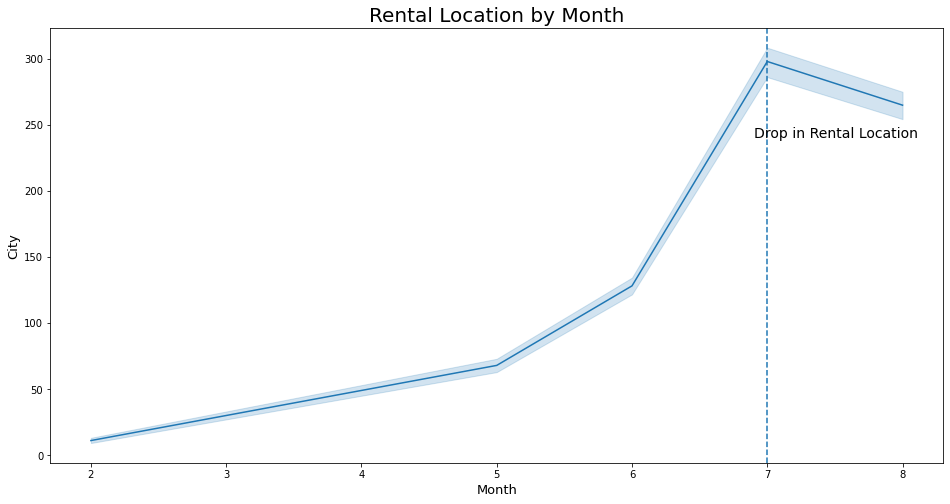

In [118]:
plt.figure(figsize=(16,8))

sns.lineplot(data=df_5, x='month', y='city')

plt.title('Rental Location by Month', size=20)
plt.xlabel('Month', size=13)
plt.ylabel('City',size=13)
plt.text(6.9,240,'Drop in Rental Location', fontsize=14)
plt.axvline(x=7,linestyle='--')

This drop on store location explain the decrease on payment. Further investigation on the reason for closure is needed, so we can analyze the data to avoid similar occurence.

# CONCLUSION

From the data we found:
1. that there are difference on payment mean
2. most of our payment are overdue and charge with penalty
3. we have a dip on our payment between month 7 and 8
4. our rental location also dropped on that same month


To do:
1. adjust the rental duration and rate accordingly
2. investigate the reason of the rental location closure